# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
Data lacks meaning.

2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?
words paired together have different meanings.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [1]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib

In [26]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText
from gensim.models import Phrases

In [2]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johnpaultamburro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnpaultamburro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [3]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'
fetch_20newsgroups = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
data = fetch_20newsgroups
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [4]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?

To ensure data is clean.

2. Name one situation where removing stopwords could be a bad idea.

Certain 'stop words', such as not, hold key information (negation).

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [5]:
# TODO: Train Word2Vec (Skip-gram)

# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(
    sentences= corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1
)
print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [6]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector
# YOUR CODE HERE
computer_vector = w2v.wv["computer"]
print("First 10 values of the 'computer' vector:")
print(computer_vector[:10])

First 10 values of the 'computer' vector:
[-0.19481863  0.5282838  -0.62232304  0.06514065 -0.31762838 -0.6134186
 -0.6653553   0.18042578  0.60839915 -0.25389388]


### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [7]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)
w2v_results = w2v.wv.most_similar("computer", topn=10)
target = "computer"
print(f"Most similar words to '{target}':")

# YOUR CODE HERE - iterate through the results and print each word and score
for word, score in w2v_results:
    print(f"Word: {word}, Score: {score}")

Most similar words to 'computer':
Word: networks, Score: 0.7090867161750793
Word: engineering, Score: 0.6888470649719238
Word: shopper, Score: 0.6838939189910889
Word: transmits, Score: 0.6836811900138855
Word: isdn, Score: 0.6836591958999634
Word: technologies, Score: 0.6806625127792358
Word: communication, Score: 0.6719413995742798
Word: electronic, Score: 0.6635185480117798
Word: architecture, Score: 0.6601987481117249
Word: conferencing, Score: 0.6583386659622192


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?

Both.

2. Pick 1 surprising neighbor and propose a reason it might appear.

Shopper. People shop with them and/or for them.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [8]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
w2v.wv.most_similar(
    positive=["king", "woman"], 
    negative=["man"], 
    topn=5)
    

[('rodney', 0.7646962404251099),
 ('joseph', 0.7640926241874695),
 ('deposition', 0.7498389482498169),
 ('omar', 0.7490966320037842),
 ('spence', 0.7477877140045166)]

### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [9]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [10]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))
import numpy as np
from numpy.linalg import norm

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.6208


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

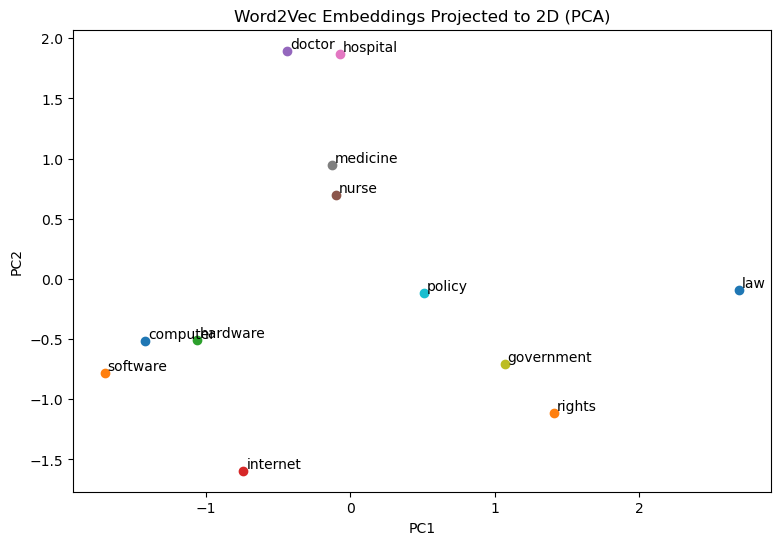

In [11]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?

Medicine and Nurse; to the point their text overlaps.

2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

There are in factxthese three clusters, but they are sparse.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [12]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [13]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
print(ft.wv.most_similar(query, topn=5))

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    print(w2v.wv.most_similar(query, topn=5))
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
[('comics', 0.9728725552558899), ('computes', 0.9726198315620422), ('compute', 0.959907054901123), ('compact', 0.9537961483001709), ('company', 0.9473526477813721)]

Word2Vec neighbors for: computers
[('multimedia', 0.8867359757423401), ('discounts', 0.8616249561309814), ('platforms', 0.8597584962844849), ('reviews', 0.8528029918670654), ('rsi', 0.8513272404670715)]


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [14]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    if word not in model.wv:
        return None
    else:
        return model.wv.most_similar(word, topn=topn)

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  airport         0.891
  marine          0.878
  northwest       0.877
  theatre         0.871
  downtown        0.867
  mall            0.866
  plaza           0.865
  alaska          0.865

Query: space
  shuttle         0.730
  nasa            0.708
  jenks           0.659
  redesign        0.657
  launch          0.656
  exploration     0.652
  flight          0.639
  station         0.638

Query: religion
  religions       0.842
  religious       0.839
  homosexuality   0.836
  intellectual    0.831
  judaism         0.828
  mormons         0.827
  viewpoint       0.823
  doctrines       0.822

Query: graphics
  cad             0.849
  gems            0.840
  radiosity       0.840
  workshop        0.817
  animation       0.817
  packages        0.813
  silicon         0.809
  multimedia      0.809


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?

The Religion Query is absolutely not helpful, as it brings up random stuff such as silicon and svga.

2. What could go wrong if we deploy this directly in production?

This semantic search would be very inconsistent, provided accurate (albeit imperfect) results in some cases, such the space query, but  terrible results in others, as religion demonstrates.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?

These problems are addressed by embeddings by ensuring the data is compact, dense, and contains semantically rich vectors. Embeddings map words in such a way
that items which are semantically similar will be closer together. Embedddings acquire its 'semantic knowledge' via training, which allows it to capture and reflect
specific relationships and contexts.


2. What is a realistic industry task where word embeddings are useful?

A realistic industry task where work embeddings are useful is Semantic Search and Information Retrieval. This is because  they allow systems to understand the meaning and context contained in a request, allowing them to find solid results even if the exact words are not used.

3. When would you choose FastText over Word2Vec?

There are three main instances of when you would choose FastText over Word2Vec. First, FastText is better for dealing with lots of rare or OOV words, meaning in instances there a lot of them in (or not in) your data, FastText may be the better option. Secondly, when working in lots of morphologically rich languages, FastText is better suited for considering all this morphological information; including aspects like prefixs, suffixes, roots. Finally, when handling Text Classification, FastText is better at this task as it was designed with that in mind.


4. What is one risk or limitation of word embeddings that a practitioner should watch for?

A core risk that should be watched out for is the perpetuation and amplification of societal biases present in training data. This can have an array of negative outcomes, such as skewing the algorithm's output and handling tasks unfairly or amplifying stereotypes. These are difficult to detect, however, due to how deeply embedded in the geometric structure of the vector space they are, meaning rigorous and specialized will often be required to remove it, at least partially.



---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [40]:
Aw2v = Word2Vec(
    sentences= corpus,
    vector_size=100,
    window=2,
    min_count=5,
    workers=4,
    sg=1
)
print("Vocabulary size:", len(Aw2v.wv))

Bw2v = Word2Vec(
    sentences= corpus,
    vector_size=100,
    window=10,
    min_count=5,
    workers=4,
    sg=1
)
print("Vocabulary size:", len(Bw2v.wv))

Xw2v = Word2Vec(
    sentences= corpus,
    vector_size=50,
    window=2,
    min_count=5,
    workers=4,
    sg=1
)
print("Vocabulary size:", len(Xw2v.wv))

Cw2v = Word2Vec(
    sentences= corpus,
    vector_size=200,
    window=2,
    min_count=5,
    workers=4,
    sg=1
)
print("Vocabulary size:", len(Cw2v.wv))

Dw2v = Word2Vec(
    sentences= corpus,
    vector_size=100,
    window=2,
    min_count=5,
    workers=4,
    sg=0
)
print("Vocabulary size:", len(Dw2v.wv))

phrases = Phrases(corpus, min_count=5, threshold=10)
corpus_bigrams = phrases[corpus]
Ew2v = Word2Vec(
    sentences= corpus,
    vector_size=100,
    window=2,
    min_count=5,
    workers=4,
    sg=0
)
print("Vocabulary size:", len(Ew2v.wv))

Vocabulary size: 18095
Vocabulary size: 18095
Vocabulary size: 18095
Vocabulary size: 18095
Vocabulary size: 18095
Vocabulary size: 18095


In [41]:
for q in queries:
    result = semantic_neighbors(Aw2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")




Query: motel
  (word not in vocabulary)

Query: hotel
  plaza           0.955
  melbourne       0.955
  tucson          0.950
  ireland         0.947
  mpce            0.947
  laboratories    0.946
  headquarters    0.946
  theatre         0.945

Query: space
  shuttle         0.754
  nasa            0.703
  redesign        0.684
  lunar           0.672
  launch          0.669
  flight          0.665
  exploration     0.663
  planetary       0.634

Query: religion
  christian       0.922
  doctrines       0.917
  christianity    0.912
  religions       0.910
  theology        0.906
  scholars        0.904
  mormon          0.901
  teaching        0.899

Query: graphics
  silicon         0.892
  programming     0.886
  cad             0.874
  animation       0.873
  borland         0.862
  multimedia      0.858
  workshop        0.857
  manipulation    0.856


In [42]:
for q in queries:
    result = semantic_neighbors(Bw2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")




Query: motel
  (word not in vocabulary)

Query: hotel
  accomodation    0.853
  meals           0.850
  quincy          0.836
  voucher         0.829
  victoria        0.822
  hotels          0.821
  alaska          0.812
  campus          0.801

Query: space
  shuttle         0.719
  nasa            0.667
  planetary       0.635
  billboards      0.634
  jenks           0.627
  exploration     0.620
  station         0.614
  jsc             0.611

Query: religion
  christianity    0.808
  fundamentalist  0.789
  religious       0.787
  religions       0.785
  paganism        0.782
  diversity       0.781
  judaism         0.775
  gender          0.773

Query: graphics
  cad             0.771
  animation       0.766
  gems            0.754
  radiosity       0.747
  iris            0.743
  morphing        0.742
  raytracing      0.740
  workshop        0.732


In [43]:
for q in queries:
    result = semantic_neighbors(Xw2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  mpce            0.957
  plaza           0.953
  macquarie       0.949
  sheriff         0.948
  theatre         0.946
  oasis           0.945
  wallops         0.945
  princeton       0.944

Query: space
  shuttle         0.765
  nasa            0.737
  lunar           0.728
  launch          0.726
  probes          0.698
  exploration     0.692
  flight          0.688
  missions        0.686

Query: religion
  christian       0.922
  christianity    0.921
  doctrines       0.914
  beings          0.914
  teaching        0.912
  religions       0.902
  traditional     0.902
  doctrine        0.899

Query: graphics
  silicon         0.896
  animation       0.882
  cad             0.872
  programming     0.856
  visualization   0.856
  manipulation    0.856
  rendering       0.854
  packages        0.851


In [44]:
for q in queries:
    result = semantic_neighbors(Cw2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")




Query: motel
  (word not in vocabulary)

Query: hotel
  mpce            0.966
  sheriff         0.964
  plaza           0.964
  nationwide      0.960
  theatre         0.959
  macquarie       0.956
  princeton       0.956
  boulevard       0.955

Query: space
  shuttle         0.719
  nasa            0.707
  flight          0.686
  launch          0.680
  redesign        0.673
  lunar           0.668
  exploration     0.653
  missions        0.642

Query: religion
  religions       0.927
  doctrines       0.924
  christian       0.920
  christianity    0.919
  islam           0.917
  mormon          0.913
  doctrine        0.912
  scholars        0.911

Query: graphics
  silicon         0.889
  cad             0.886
  programming     0.873
  borland         0.869
  animation       0.868
  packages        0.867
  manipulation    0.866
  routines        0.863


In [36]:
for q in queries:
    result = semantic_neighbors(Dw2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")




Query: motel
  (word not in vocabulary)

Query: hotel
  headquarters    0.995
  johansson       0.995
  faust           0.995
  hill            0.995
  paris           0.995
  metropolitan    0.994
  ku              0.994
  desjardins      0.994

Query: space
  shuttle         0.833
  station         0.823
  research        0.820
  nasa            0.820
  center          0.816
  launch          0.799
  local           0.793
  aeronautics     0.783

Query: religion
  existence       0.976
  islam           0.975
  belief          0.975
  christian       0.973
  beliefs         0.973
  christianity    0.973
  nature          0.970
  authority       0.970

Query: graphics
  ibm             0.971
  programming     0.970
  macintosh       0.967
  interface       0.965
  unix            0.963
  modem           0.958
  software        0.950
  processing      0.950


In [37]:
for q in queries:
    result = semantic_neighbors(Ew2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  med             0.996
  consultant      0.994
  tucson          0.994
  atmospheric     0.994
  astronaut       0.993
  evans           0.993
  hut             0.993
  keown           0.993

Query: space
  shuttle         0.854
  station         0.824
  nasa            0.823
  research        0.821
  launch          0.815
  center          0.799
  local           0.762
  aeronautics     0.761

Query: religion
  beliefs         0.977
  christianity    0.975
  authority       0.974
  existence       0.973
  revelation      0.971
  christian       0.969
  nature          0.968
  acts            0.968

Query: graphics
  interface       0.970
  programming     0.969
  unix            0.965
  macintosh       0.963
  ibm             0.960
  software        0.957
  modem           0.954
  libraries       0.952


Comparissons:
- For 2 and 10 window, the latter provides more accurate results for the hotel query, but provides less accurate results for the religion query. The former doesn't affect the other words negatively, but the religion query gains a slight improvement

- For 50 and 200 vector size, increasing the vector size increases the probabilities for the hotel and religion queries, but decreases it for the space query. Some top results also switch spots, demonstrated in all three queries. Accuracy is also slightly increased for the space query, as it leans into the 'outer space' definition of space by removing a term related to the 'design and decorate' from the top list, that being redesign.

- For CBOW vs non-CBOW, probabilities for the hotel and religion queries are higher, while those for religion are lower. Accuracy for the space query is higher, notably as shuttle is right below station; being two of the prime thoughs when thinking of 'outer' space.

- Introducing Bigram increases probabilities across the board. it does muck some stuff up, though, such as adding astronaut to the top spots of the hotel query.